In [1]:
import os
import shutil
import time

import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim
import torch.utils.data
import torchvision.transforms as transforms
import torchvision.datasets as datasets

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.nn.init as init

import random

from six import string_types
import torch.optim as optim
# mister_ed
import recoloradv.mister_ed.loss_functions as lf 
import recoloradv.mister_ed.utils.pytorch_utils as utils
import recoloradv.mister_ed.utils.image_utils as img_utils
import recoloradv.mister_ed.cifar10.cifar_loader as cifar_loader
import recoloradv.mister_ed.cifar10.cifar_resnets as cifar_resnets
import recoloradv.mister_ed.adversarial_training as advtrain
import recoloradv.mister_ed.utils.checkpoints as checkpoints
import recoloradv.mister_ed.adversarial_perturbations as ap 
import recoloradv.mister_ed.adversarial_attacks as aa
import recoloradv.mister_ed.spatial_transformers as st
import recoloradv.mister_ed.config as config

# ReColorAdv
import recoloradv.perturbations as pt
import recoloradv.color_transformers as ct
import recoloradv.color_spaces as cs
from recoloradv import norms
from recoloradv.utils import load_pretrained_cifar10_model, get_attack_from_name

import matplotlib.pyplot as plt
import numpy as np
import copy
import cv2

C:\Users\bodhi\miniconda3\envs\machine learning in CS\lib\site-packages\torchvision\io\image.py:11: UserWarning: Failed to load image Python extension: Could not find module 'C:\Users\bodhi\miniconda3\envs\machine learning in CS\Lib\site-packages\torchvision\image.pyd' (or one of its dependencies). Try using the full path with constructor syntax.
  warn(f"Failed to load image Python extension: {e}")


In [2]:
## resnet model
def _weights_init(m):
    classname = m.__class__.__name__
    #print(classname)
    if isinstance(m, nn.Linear) or isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight)

class LambdaLayer(nn.Module):
    def __init__(self, lambd):
        super(LambdaLayer, self).__init__()
        self.lambd = lambd

    def forward(self, x):
        return self.lambd(x)


class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_planes, planes, stride=1, option='A'):
        super(BasicBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)

        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != planes:
            if option == 'A':
                """
                For CIFAR10 ResNet paper uses option A.
                """
                self.shortcut = LambdaLayer(lambda x:
                                            F.pad(x[:, :, ::2, ::2], (0, 0, 0, 0, planes//4, planes//4), "constant", 0))
            elif option == 'B':
                self.shortcut = nn.Sequential(
                     nn.Conv2d(in_planes, self.expansion * planes, kernel_size=1, stride=stride, bias=False),
                     nn.BatchNorm2d(self.expansion * planes)
                )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x)
        out = F.relu(out)
        return out


class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 16

        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(16)
        self.layer1 = self._make_layer(block, 16, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 32, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 64, num_blocks[2], stride=2)
        self.linear = nn.Linear(64, num_classes)

        self.apply(_weights_init)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1]*(num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.expansion

        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = F.avg_pool2d(out, out.size()[3])
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out


def resnet20():
    return ResNet(BasicBlock, [3, 3, 3])


def resnet32():
    return ResNet(BasicBlock, [5, 5, 5])


def resnet44():
    return ResNet(BasicBlock, [7, 7, 7])


def resnet56():
    return ResNet(BasicBlock, [9, 9, 9])


def resnet110():
    return ResNet(BasicBlock, [18, 18, 18])


def resnet1202():
    return ResNet(BasicBlock, [200, 200, 200])


def test(net):
    import numpy as np
    total_params = 0

    for x in filter(lambda p: p.requires_grad, net.parameters()):
        total_params += np.prod(x.data.numpy().shape)
    print("Total number of params", total_params)
    print("Total layers", len(list(filter(lambda p: p.requires_grad and len(p.data.size())>1, net.parameters()))))

In [3]:
## attack algorithm (nothing changes functionswise but i edit it to keep the images it produces)

class AdversarialAttack(object):
    """ Wrapper for adversarial attacks. Is helpful for when subsidiary methods
        are needed.
    """

    def __init__(self, classifier_net, normalizer, threat_model,
                 manual_gpu=None):
        """ Initializes things to hold to perform a single batch of
            adversarial attacks
        ARGS:
            classifier_net : nn.Module subclass - neural net that is the
                             classifier we're attacking
            normalizer : DifferentiableNormalize object - object to convert
                         input data to mean-zero, unit-var examples
            threat_model : ThreatModel object - object that allows us to create
                           per-minibatch adversarial examples
            manual_gpu : None or boolean - if not None, we override the
                         environment variable 'MISTER_ED_GPU' for how we use
                         the GPU in this object
        """
        self.classifier_net = classifier_net
#         self.normalizer = normalizer or utils.IdentityNormalize()
        self.normalizer = utils.IdentityNormalize()
        if manual_gpu is not None:
            self.use_gpu = manual_gpu
        else:
            self.use_gpu = utils.use_gpu()
        self.validator = lambda *args: None
        self.threat_model = threat_model

    @property
    def _dtype(self):
        return torch.cuda.FloatTensor if self.use_gpu else torch.FloatTensor

    def setup(self):
        self.classifier_net.eval()
        self.normalizer.differentiable_call()


    def eval(self, ground_examples, adversarials, labels, topk=1):
        """ Evaluates how good the adversarial examples are
        ARGS:
            ground_truths: Variable (NxCxHxW) - examples before we did
                           adversarial perturbation. Vals in [0, 1] range
            adversarials: Variable (NxCxHxW) - examples after we did
                           adversarial perturbation. Should be same shape and
                           in same order as ground_truth
            labels: Variable (longTensor N) - correct labels of classification
                    output
        RETURNS:
            tuple of (% of correctly classified original examples,
                      % of correctly classified adversarial examples)
        """
        normed_ground = self.normalizer.forward(ground_examples)
        ground_output = self.classifier_net.forward(normed_ground)
        ground_ouput = ground_output[:, :, 0]
        normed_advs = self.normalizer.forward(adversarials)
        adv_output = self.classifier_net.forward(normed_advs)
        adv_output = adv_output[:,:,0]

        start_prec = utils.accuracy(ground_output.data, labels.data,
                                    topk=(topk,))
        adv_prec = utils.accuracy(adv_output.data, labels.data,
                                  topk=(topk,))

        return float(start_prec[0]), float(adv_prec[0])
    
    def eval_attack_only(self, adversarials, labels, topk=1):
        """ Outputs the accuracy of the adv_inputs only
        ARGS:
            adv_inputs: Variable NxCxHxW - examples after we did adversarial
                                           perturbation
            labels: Variable (longtensor N) - correct labels of classification
                                              output
            topk: int - criterion for 'correct' classification
        RETURNS:
            (int) number of correctly classified examples
        """

        normed_advs = self.normalizer.forward(adversarials)

        adv_output = self.classifier_net.forward(normed_advs)
        return utils.accuracy_int(adv_output, labels, topk=topk)



    def print_eval_str(self, ground_examples, adversarials, labels, topk=1):
        """ Prints how good this adversarial attack is
            (explicitly prints out %CorrectlyClassified(ground_examples)
            vs %CorrectlyClassified(adversarials)
        ARGS:
            ground_truths: Variable (NxCxHxW) - examples before we did
                           adversarial perturbation. Vals in [0, 1] range
            adversarials: Variable (NxCxHxW) - examples after we did
                           adversarial perturbation. Should be same shape and
                           in same order as ground_truth
            labels: Variable (longTensor N) - correct labels of classification
                    output
        RETURNS:
            None, prints some stuff though
        """

        og, adv = self.eval(ground_examples, adversarials, labels, topk=topk)
        print("Went from %s correct to %s correct" % (og, adv))



    def validation_loop(self, examples, labels, iter_no=None):
        """ Prints out validation values interim for use in iterative techniques
        ARGS:
            new_examples: Variable (NxCxHxW) - [0.0, 1.0] images to be
                          classified and compared against labels
            labels: Variable (longTensor
            N) - correct labels for indices of
                             examples
            iter_no: String - an extra thing for prettier prints
        RETURNS:
            None
        """
        normed_input = self.normalizer.forward(examples)
        new_output = self.classifier_net.forward(normed_input)
        
        
        new_prec = utils.accuracy(new_output.data, labels.data, topk=(1,))
        print_str = ""
        if isinstance(iter_no, int):
            if iter_no %10 == 0:
                print_str += "(iteration %02d): " % iter_no
#         elif isinstance(iter_no, string_types):
#             print_str += "(%s): " % iter_no
        else:
            pass

        print_str += " %s correct" % float(new_prec[0])

        print(print_str)

class PGD(AdversarialAttack):

    def __init__(self, classifier_net, normalizer, threat_model, loss_fxn,
                 manual_gpu=None):
        super(PGD, self).__init__(classifier_net, normalizer, threat_model,
                                  manual_gpu=manual_gpu)
        self.loss_fxn = loss_fxn # WE MAXIMIZE THIS!!!

    def attack(self, examples, labels, step_size=1.0/255.0,
               num_iterations=20, random_init=False, signed=True,
               optimizer=None, optimizer_kwargs=None,
               loss_convergence=0.999, verbose=True,
               keep_best=True):
        """ Builds PGD examples for the given examples with l_inf bound and
            given step size. Is almost identical to the BIM attack, except
            we take steps that are proportional to gradient value instead of
            just their sign.
        ARGS:
            examples: NxCxHxW tensor - for N examples, is NOT NORMALIZED
                      (i.e., all values are in between 0.0 and 1.0)
            labels: N longTensor - single dimension tensor with labels of
                    examples (in same order as examples)
            l_inf_bound : float - how much we're allowed to perturb each pixel
                          (relative to the 0.0, 1.0 range)
            step_size : float - how much of a step we take each iteration
            num_iterations: int or pair of ints - how many iterations we take.
                            If pair of ints, is of form (lo, hi), where we run
                            at least 'lo' iterations, at most 'hi' iterations
                            and we quit early if loss has stabilized.
            random_init : bool - if True, we randomly pick a point in the
                               l-inf epsilon ball around each example
            signed : bool - if True, each step is
                            adversarial = adversarial + sign(grad)
                            [this is the form that madry et al use]
                            if False, each step is
                            adversarial = adversarial + grad
            keep_best : bool - if True, we keep track of the best adversarial
                               perturbations per example (in terms of maximal
                               loss) in the minibatch. The output is the best of
                               each of these then
        RETURNS:
            AdversarialPerturbation object with correct parameters.
            Calling perturbation() gets Variable of output and
            calling perturbation().data gets tensor of output
        """

        ######################################################################
        #   Setups and assertions                                            #
        ######################################################################

        self.classifier_net.eval()

        if not verbose:
            self.validator = lambda ex, label, iter_no: None
        else:
            self.validator = self.validation_loop

        perturbation = self.threat_model(examples)

        num_examples = examples.shape[0]
        var_examples = Variable(examples, requires_grad=True)
        var_labels = Variable(labels, requires_grad=False)

        if isinstance(num_iterations, int):
            min_iterations = num_iterations
            max_iterations = num_iterations
        elif isinstance(num_iterations, tuple):
            min_iterations, max_iterations = num_iterations

        best_perturbation = None
        if keep_best:
            best_loss_per_example = {i: None for i in range(num_examples)}

        prev_loss = None

        ######################################################################
        #   Loop through iterations                                          #
        ######################################################################

        self.loss_fxn.setup_attack_batch(var_examples)
        self.validator(var_examples, var_labels, iter_no="START")

        # random initialization if necessary
        if random_init:
            perturbation.random_init()
            self.validator(perturbation(var_examples), var_labels,
                           iter_no="RANDOM")

        # Build optimizer techniques for both signed and unsigned methods
        optimizer = optimizer or optim.Adam
        if optimizer_kwargs is None:
            optimizer_kwargs = {'lr':0.0001}
        optimizer = optimizer(perturbation.parameters(), **optimizer_kwargs)

        update_fxn = lambda grad_data: -1 * step_size * torch.sign(grad_data)


        for iter_no in range(max_iterations):
            perturbation.zero_grad()
            loss = self.loss_fxn.forward(perturbation(var_examples), var_labels,
                                         perturbation=perturbation,
                                         output_per_example=keep_best)
            loss_per_example = loss
            loss = loss.sum()

            loss = -1 * loss
            torch.autograd.backward(loss.sum())

            if signed:
                perturbation.update_params(update_fxn)
            else:
                optimizer.step()

            if keep_best:
                mask_val = torch.zeros(num_examples, dtype=torch.uint8)
                for i, el in enumerate(loss_per_example):
                    this_best_loss = best_loss_per_example[i]
                    if this_best_loss is None or this_best_loss[1] < float(el):
                        mask_val[i] = 1
                        best_loss_per_example[i] = (iter_no, float(el))

                if best_perturbation is None:
                    best_perturbation = self.threat_model(examples)

                best_perturbation = perturbation.merge_perturbation(
                                                            best_perturbation,
                                                            mask_val)


            self.validator((best_perturbation or perturbation)(var_examples),
                           var_labels, iter_no=iter_no)

            # Stop early if loss didn't go down too much
            if (iter_no >= min_iterations and
                float(loss) >= loss_convergence * prev_loss):
                if verbose:
                    print("Stopping early at %03d iterations" % iter_no)
                break
            prev_loss = float(loss)



        perturbation.zero_grad()
        self.loss_fxn.cleanup_attack_batch()
        perturbation.attach_originals(examples)
        return perturbation

import torch.nn as nn
import torch
from numbers import Number
# from .utils import pytorch_utils as utils
# from .utils import image_utils as img_utils
# from . import spatial_transformers as st
from torch.autograd import Variable
from functools import partial
# from . import adversarial_perturbations as ap

""" Loss function building blocks """

##############################################################################
#                                                                            #
#                        LOSS FUNCTION WRAPPER                               #
#                                                                            #
##############################################################################

class RegularizedLoss(object):
    """ Wrapper for multiple PartialLoss objects where we combine with
        regularization constants """
    def __init__(self, losses, scalars, negate=False):
        """
        ARGS:
            losses : dict - dictionary of partialLoss objects, each is keyed
                            with a nice identifying name
            scalars : dict - dictionary of scalars, each is keyed with the
                             same identifying name as is in self.losses
            negate : bool - if True, we negate the whole thing at the end
        """

        assert sorted(losses.keys()) == sorted(scalars.keys())

        self.losses = losses
        self.scalars = scalars
        self.negate = negate

    def forward(self, examples, labels, *args, **kwargs):

        output = None
        output_per_example = kwargs.get('output_per_example', False)
        for k in self.losses:
            loss = self.losses[k]
            scalar = self.scalars[k]
            loss_val = loss.forward(examples, labels, *args, **kwargs)
            # assert scalar is either a...
            assert (isinstance(scalar, float) or # number
                    scalar.numel() == 1 or # tf wrapping of a number
                    scalar.shape == loss_val.shape) # same as the loss_val

            addendum = loss_val * scalar
            if addendum.numel() > 1:
                if not output_per_example:
                    addendum = torch.sum(addendum)

            if output is None:
                output = addendum
            else:
                output = output + addendum
        if self.negate:
            return output * -1
        else:
            return output


    def setup_attack_batch(self, fix_im):
        """ Setup before calling loss on a new minibatch. Ensures the correct
            fix_im for reference regularizers and that all grads are zeroed
        ARGS:
            fix_im: Variable (NxCxHxW) - Ground images for this minibatch
                    SHOULD BE IN [0.0, 1.0] RANGE
        """
        for loss in self.losses.values():
            if isinstance(loss, ReferenceRegularizer):
                loss.setup_attack_batch(fix_im)
            else:
                loss.zero_grad()


    def cleanup_attack_batch(self):
        """ Does some cleanup stuff after we finish on a minibatch:
        - clears the fixed images for ReferenceRegularizers
        - zeros grads
        - clears example-based scalars (i.e. scalars that depend on which
          example we're using)
        """
        for loss in self.losses.values():
            if isinstance(loss, ReferenceRegularizer):
                loss.cleanup_attack_batch()
            else:
                loss.zero_grad()

        for key, scalar in self.scalars.items():
            if not isinstance(scalar, Number):
                self.scalars[key] = None


    def zero_grad(self):
        for loss in self.losses.values():
            loss.zero_grad() # probably zeros the same net more than once...



class PartialLoss(object):
    """ Partially applied loss object. Has forward and zero_grad methods """
    def __init__(self):
        self.nets = []

    def zero_grad(self):
        for net in self.nets:
            net.zero_grad()


##############################################################################
#                                                                            #
#                                  LOSS FUNCTIONS                            #
#                                                                            #
##############################################################################

############################################################################
#                       NAIVE CORRECT INDICATOR LOSS                       #
############################################################################

class IncorrectIndicator(PartialLoss):
    def __init__(self, classifier, normalizer=None):
        super(IncorrectIndicator, self).__init__()
        self.classifier = classifier
        self.normalizer = normalizer

    def forward(self, examples, labels, *args, **kwargs):
        """ Returns either (the number | a boolean vector) of examples that
            don't match the labels when run through the
            classifier(normalizer(.)) composition.
        ARGS:
            examples: Variable (NxCxHxW) - should be same shape as
                      ctx.fix_im, is the examples we define loss for.
                      SHOULD BE IN [0.0, 1.0] RANGE
            labels: Variable (longTensor of length N) - true classification
                    output for fix_im/examples
        KWARGS:
            return_type: String - either 'int' or 'vector'. If 'int', we return
                         the number of correctly classified examples,
                         if 'vector' we return a boolean length-N longtensor
                         with the indices of
        RETURNS:
            scalar loss variable or boolean vector, depending on kwargs
        """
        return_type = kwargs.get('return_type', 'int')
        assert return_type in ['int', 'vector']

        class_out = self.classifier.forward(self.normalizer.forward(examples))

        _, outputs = torch.max(class_out, 1)
        incorrect_indicator = outputs != labels

        if return_type == 'int':
            return torch.sum(incorrect_indicator)
        else:
            return incorrect_indicator



##############################################################################
#                                   Standard XEntropy Loss                   #
##############################################################################

class PartialXentropy(PartialLoss):
    def __init__(self, classifier, normalizer=None):
        super(PartialXentropy, self).__init__()
        self.classifier = classifier
        self.normalizer = normalizer
        self.nets.append(self.classifier)

    def forward(self, examples, labels, *args, **kwargs):
        """ Returns XEntropy loss
        ARGS:
            examples: Variable (NxCxHxW) - should be same shape as
                      ctx.fix_im, is the examples we define loss for.
                      SHOULD BE IN [0.0, 1.0] RANGE
            labels: Variable (longTensor of length N) - true classification
                    output for fix_im/examples
        RETURNS:
            scalar loss variable
        """

        if self.normalizer is not None:
            normed_examples = self.normalizer.forward(examples)
        else:
            normed_examples = examples

        xentropy_init_kwargs = {}
        if kwargs.get('output_per_example') == True:
            xentropy_init_kwargs['reduction'] = 'none'
        criterion = nn.CrossEntropyLoss(**xentropy_init_kwargs)
        return criterion(self.classifier.forward(normed_examples), labels)

##############################################################################
#                           Carlini Wagner loss functions                    #
##############################################################################

class CWLossF6(PartialLoss):
    def __init__(self, classifier, normalizer=None, kappa=0.0):
        super(CWLossF6, self).__init__()
        self.classifier = classifier
#         self.normalizer = normalizer
        self.normalizer = normalizer or utils.IdentityNormalize()
        self.nets.append(self.classifier)
        self.kappa = kappa


    def forward(self, examples, labels, *args, **kwargs):
        classifier_in = self.normalizer.forward(examples)
        classifier_out = self.classifier.forward(classifier_in)
        
#         print(new_output.shape)
        
        # get target logits
        target_logits = torch.gather(classifier_out, 1, labels.view(-1, 1))

        # get largest non-target logits
        max_2_logits, argmax_2_logits = torch.topk(classifier_out, 2, dim=1)
        top_max, second_max = max_2_logits.chunk(2, dim=1)
        top_argmax, _ = argmax_2_logits.chunk(2, dim=1)
        targets_eq_max = top_argmax.squeeze().eq(labels).float().view(-1, 1)
        targets_ne_max = top_argmax.squeeze().ne(labels).float().view(-1, 1)
        max_other = targets_eq_max * second_max + targets_ne_max * top_max


        if kwargs.get('targeted', False):
            # in targeted case, want to make target most likely
            f6 = torch.clamp(max_other - target_logits, min=-1 * self.kappa)
        else:
            # in NONtargeted case, want to make NONtarget most likely
            f6 = torch.clamp(target_logits - max_other, min=-1 * self.kappa)

        return f6.squeeze()





##############################################################################
#                                                                            #
#                               REFERENCE REGULARIZERS                       #
#                                                                            #
##############################################################################
""" Regularization terms that refer back to a set of 'fixed images', or the
    original images.
    example: L2 regularization which computes L2dist between a perturbed image
             and the FIXED ORIGINAL IMAGE
    NOTE: it's important that these return Variables that are scalars
    (output.numel() == 1), otherwise there's a memory leak w/ CUDA.
    See my discussion on this here:
        https://discuss.pytorch.org/t/cuda-memory-not-being-freed/15965
"""

class ReferenceRegularizer(PartialLoss):
    def __init__(self, fix_im):
        super(ReferenceRegularizer, self).__init__()
        self.fix_im = fix_im

    def setup_attack_batch(self, fix_im):
        """ Setup function to ensure fixed images are set
            has been made; also zeros grads
        ARGS:
            fix_im: Variable (NxCxHxW) - Ground images for this minibatch
                    SHOULD BE IN [0.0, 1.0] RANGE
        """
        self.fix_im = fix_im
        self.zero_grad()


    def cleanup_attack_batch(self):
        """ Cleanup function to clear the fixed images after an attack batch
            has been made; also zeros grads
        """
        old_fix_im = self.fix_im
        self.fix_im = None
        del old_fix_im
        self.zero_grad()


#############################################################################
#                               SOFT L_INF REGULARIZATION                   #
#############################################################################

class SoftLInfRegularization(ReferenceRegularizer):
    '''
        see page 10 of this paper (https://arxiv.org/pdf/1608.04644.pdf)
        for discussion on why we want SOFT l inf
    '''
    def __init__(self, fix_im, **kwargs):
        super(SoftLInfRegularization, self).__init__(fix_im)

    def forward(self, examples, *args, **kwargs):
        # ARGS should have one element, which serves as the tau value

        tau =  8.0 / 255.0  # starts at 1 each time?
        scale_factor = 0.9
        l_inf_dist = float(torch.max(torch.abs(examples - self.fix_im)))
        '''
        while scale_factor * tau > l_inf_dist:
            tau *= scale_factor
        assert tau > l_inf_dist
        '''
        delta_minus_taus = torch.clamp(torch.abs(examples - self.fix_im) - tau,
                                       min=0.0)
        batchwise = utils.batchwise_norm(delta_minus_taus, 'inf', dim=0)
        return batchwise.squeeze()



#############################################################################
#                               L2 REGULARIZATION                           #
#############################################################################

class L2Regularization(ReferenceRegularizer):

    def __init__(self, fix_im, **kwargs):
        super(L2Regularization, self).__init__(fix_im)

    def forward(self, examples, *args, **kwargs):
        l2_dist = img_utils.nchw_l2(examples, self.fix_im,
                                    squared=True).view(-1, 1)
        return l2_dist.squeeze()

#############################################################################
#                         LPIPS PERCEPTUAL REGULARIZATION                   #
#############################################################################

class LpipsRegularization(ReferenceRegularizer):

    def __init__(self, fix_im, **kwargs):
        super(LpipsRegularization, self).__init__(fix_im)

        manual_gpu = kwargs.get('manual_gpu', None)
        if manual_gpu is not None:
            self.use_gpu = manual_gpu
        else:
            self.use_gpu = utils.use_gpu()

        self.dist_model = dm.DistModel(net='alex', manual_gpu=self.use_gpu)

    def forward(self, examples, *args, **kwargs):
        xform = lambda im: im * 2.0 - 1.0
        perceptual_loss = self.dist_model.forward_var(examples,
                                                      self.fix_im)

        return perceptual_loss.squeeze()

#############################################################################
#                         SSIM PERCEPTUAL REGULARIZATION                    #
#############################################################################

class SSIMRegularization(ReferenceRegularizer):

    def __init__(self, fix_im, **kwargs):
        super(SSIMRegularization, self).__init__(fix_im)

        if 'window_size' in kwargs:
            self.ssim_instance = ssim.SSIM(window_size=kwargs['window_size'])
        else:
            self.ssim_instance = ssim.SSIM()

        manual_gpu = kwargs.get('manual_gpu', None)
        if manual_gpu is not None:
            self.use_gpu = manual_gpu
        else:
            self.use_gpu = utils.use_gpu()


    def forward(self, examples, *args, **kwargs):
        output = []
        for ex, fix_ex in zip(examples, self.fix_im):
            output.append(1.0 - self.ssim_instance(ex.unsqueeze(0),
                                                   fix_ex.unsqueeze(0)))
        return torch.stack(output)


##############################################################################
#                                                                            #
#                           SPATIAL LOSS FUNCTIONS                           #
#                                                                            #
##############################################################################

class FullSpatialLpLoss(PartialLoss):
    """ Spatial loss using lp norms on the spatial transformation parameters
    This is defined as the Lp difference between the identity map and the
    provided spatial transformation parameters
    """

    def __init__(self, **kwargs):
        super(FullSpatialLpLoss, self).__init__()

        lp = kwargs.get('lp', 2)
        assert lp in [1, 2, 'inf']
        self.lp = lp

    def forward(self, examples, *args, **kwargs):
        """ Computes lp loss between identity map and spatial transformation.
            There better be a kwarg with key 'spatial' which is as FullSpatial
            object describing how the examples were generated from the originals
        """
        st_obj = kwargs['spatial']
        assert isinstance(st_obj, st.FullSpatial)


        # First create the identity map and make same type as examples
        identity_map = Variable(st_obj.identity_params(examples.shape))
        if examples.is_cuda:
            identity_map.cuda()

        # Then take diffs and take lp norms
        diffs = st_obj.grid_params - identity_map
        lp_norm = utils.batchwise_norm(diffs, self.lp, dim=0)
        return lp_norm # return Nx1 variable, will sum in parent class


class PerturbationNormLoss(PartialLoss):

    def __init__(self, **kwargs):
        super(PerturbationNormLoss, self).__init__()

        lp = kwargs.get('lp', 2)
        assert lp in [1, 2, 'inf']
        self.lp = lp


    def forward(self, examples, *args, **kwargs):
        """ Computes perturbation norm and multiplies by scale
        There better be a kwarg with key 'perturbation' which is a perturbation
        object with a 'perturbation_norm' method that takes 'lp_style' as a
        kwarg
        """

        perturbation = kwargs['perturbation']
        assert isinstance(perturbation, AdversarialPerturbation)

        return perturbation.perturbation_norm(lp_style=self.lp)




##############################################################################
#                                                                            #
#                       Combined Transformer Loss                            #
#                                                                            #
##############################################################################

class CombinedTransformerLoss(ReferenceRegularizer):
    """ General class for distance functions and loss functions of the form
    min_T ||X - T(Y)|| + c * || T ||
    where X is the original image, and Y is the 'adversarial' input image.
    """


    def __init__(self, fix_im, transform_class=None,
                 regularization_constant=1.0,
                 transformation_loss=partial(utils.summed_lp_norm,lp=2),
                 transform_norm_kwargs=None):
        """ Takes in a reference fix im and a class of transformations we need
            to search over to compute forward.
        """
        super(CombinedTransformerLoss, self).__init__(fix_im)
        self.transform_class = transform_class
        self.regularization_constant = regularization_constant
        self.transformation_loss = transformation_loss
        self.transform_norm_kwargs = transform_norm_kwargs or {}
        self.transformer = None


    def cleanup_attack_batch(self):
        super(CombinedTransformerLoss, self).cleanup_attack_batch()
        self.transformer = None


    def _inner_loss(self, examples):
        """ Computes the combined loss for a particular transformation """

        trans_examples = self.transformer.forward(examples)
        trans_loss = self.transformation_loss(self.fix_im - trans_examples)

        trans_norm = self.transformer.norm(**self.transform_norm_kwargs)
        return trans_loss + trans_norm * self.regularization_constant


    def forward(self, examples, *args, **kwargs):
        """ Computes the distance between examples and args
        ARGS:
            examples : NxCxHxW Variable - 'adversarially' perturbed image from
                       the self.fix_im
        KWARGS:
            optimization stuff here
        """

        ######################################################################
        #   Setup transformer + optimizer                                    #
        ######################################################################
        self.transformer = self.transform_class(shape=examples.shape)


        optim_kwargs = kwargs.get('xform_loss_optim_kwargs', {})
        optim_type = kwargs.get('xform_loss_optim_type', torch.optim.Adam)
        num_iter = kwargs.get('xform_loss_num_iter', 20)

        optimizer = optim_type(self.transformer.parameters(), **optim_kwargs)

        #####################################################################
        #   Iterate and optimize the transformer                            #
        #####################################################################
        for iter_no in range(num_iter):
            optimizer.zero_grad()
            loss = self._inner_loss(examples)
            loss.backward()
            optimizer.step()

        return self._inner_loss(examples)



class RelaxedTransformerLoss(ReferenceRegularizer):
    """  Relaxed version of transformer loss: assumes that the adversarial
         examples are of the form Y=S(X) + delta for some S in the
         transformation class and some small delta perturbation outside the
         perturbation.
         In this case, we just compute ||delta|| + c||S||
         This saves us from having to do the inner minmization step
    """

    def __init__(self, fix_im,
                 regularization_constant=1.0,
                 transformation_loss=partial(utils.summed_lp_norm,lp=2),
                 transform_norm_kwargs=None):
        """ Takes in a reference fix im and a class of transformations we need
            to search over to compute forward.
        """
        super(RelaxedTransformerLoss, self).__init__(fix_im)
        self.regularization_constant = regularization_constant
        self.transformation_loss = transformation_loss
        self.transform_norm_kwargs = transform_norm_kwargs or {}


    def forward(self, examples, *args, **kwargs):
        """ Computes the distance between examples and args
        ARGS:
            examples : NxCxHxW Variable - 'adversarially' perturbed image from
                       the self.fix_im
        KWARGS:
            optimization stuff here
        """

        # Collect transformer norm
        transformer = kwargs['transformer']
        assert isinstance(transformer, st.ParameterizedTransformation)

        transformer_norm = self.regularization_constant *\
                           transformer.norm(**self.transform_norm_kwargs)

        # Collect transformation loss
        delta = self.transformer.forward(self.fix_im) - examples
        transformation_loss = self.transformation_loss(delta)

        return transformation_loss + transformer_norm
    
""" File that holds adversarial perturbations as torch.nn.Modules.
    An adversarial perturbation is an example-specific
TODO: this needs to be fleshed out, as a general technique to make adversarial
      perturbations.
"""

import torch
import torch.nn as nn
# from . import spatial_transformers as st
# from .utils import image_utils as img_utils
# from .utils import pytorch_utils as utils
from torch.autograd import Variable
import functools


# assert initialized decorator
def initialized(func):
    @functools.wraps(func)
    def wrapper(self, *args, **kwargs):
        assert self.initialized, ("Parameters not initialized yet. "
                                  "Call .forward(...) first")
        return func(self, *args, **kwargs)
    return wrapper

##############################################################################
#                                                                            #
#                                   SKELETON CLASS                           #
#                                                                            #
##############################################################################

class AdversarialPerturbation(nn.Module):
    """ Skeleton class to hold adversarial perturbations FOR A SINGLE MINIBATCH.
        For general input-agnostic adversarial perturbations, see the
        ThreatModel class
        All subclasses need the following:
        - perturbation_norm() : no args -> scalar Variable
        - self.parameters() needs to iterate over params we want to optimize
        - constrain_params() : no args -> no return,
             modifies the parameters such that this is still a valid image
        - forward : no args -> Variable - applies the adversarial perturbation
                    the originals and outputs a Variable of how we got there
        - adversarial_tensors() : applies the adversarial transform to the
                                  originals and outputs TENSORS that are the
                                  adversarial images
    """

    def __init__(self, threat_model, perturbation_params):

        super(AdversarialPerturbation, self).__init__()
        self.threat_model = threat_model
        self.initialized = False
        self.perturbation_params = perturbation_params

        if isinstance(perturbation_params, tuple):
            self.use_gpu = perturbation_params[1].use_gpu or utils.use_gpu()
        else:
            self.use_gpu = perturbation_params.use_gpu or utils.use_gpu()
        # Stores parameters of the adversarial perturbation and hyperparams
        # to compute total perturbation norm here


    def __call__(self, x):
        return self.forward(x)

    def __repr__(self):
        if isinstance(self.perturbation_params, tuple):
            output_str = "[Perturbation] %s: %s" % (self.__class__.__name__,
                                                    self.perturbation_params[1])
            output_str += '\n['
            for el in self.perturbation_params[0]:
                output_str += '\n\t%s,' % el
            output_str += '\n]'
            return output_str
        else:
            return "[Perturbation] %s: %s"  % (self.__class__.__name__,
                                               self.perturbation_params)

    def _merge_setup(self, *args):
        """ Internal method to be used when initializing a new perturbation
            from merging only. Should not be called outside this file!!
        """
        pass

    def setup(self, x):
        """ This is the standard setup technique and should be used to
            initialize a perturbation (i.e. sets up parameters and unlocks
            all other methods)
        ARGS:
            x : Variable or Tensor (NxCxHxW) - the images this perturbation is
                intended for
        """
        self.num_examples = x.shape[0]


    @initialized
    def perturbation_norm(self, x=None):
        """ This returns the 'norm' of this perturbation. Optionally, for
            certain norms, having access to the images for which the
            perturbation is intended can have an effect on the output.
        ARGS:
            x : Variable or Tensor (NxCxHxW) - optionally can be the images
                that the perturbation was intended for
        RETURNS:
            Scalar Variable
        """
        raise NotImplementedError("Need to call subclass method here")

    @initialized
    def constrain_params(self):
        """ This modifies the parameters such that the perturbation falls within
            the threat model it belongs to. E.g. for l-infinity threat models,
            this clips the params to match the right l-infinity bound.
            TODO: for non-lp norms, projecting to the nearest point in the level
                  set
        """
        raise NotImplementedError("Need to call subclass method here")

    @initialized
    def make_valid_image(self, x):
        """ This takes in the minibatch self's parameters were tuned for and
            clips the parameters such that this is still a valid image.
        ARGS:
            x : Variable or Tensor (NxCxHxW) - the images this this perturbation
                was intended for
        RETURNS:
            None
        """
        pass # Only implement in classes that can create invalid images

    @initialized
    def forward(self, x):
        """ This takes in the minibatch self's parameters were tuned for and
            outputs a variable of the perturbation applied to the images
        ARGS:
            x : Variable (NxCxHxW) - the images this this perturbation
                was intended for
        RETURNS:
            Variable (NxCxHxW) - the perturbation applied to the input images
        """
        raise NotImplementedError("Need to call subclass method here")

    @initialized
    def add_to_params(self, grad_data):
        """ This takes in a Tensor the same shape as self's parameters and
            adds to them. Note that this usually won't preserve gradient
            information
            (also this might have different signatures in subclasses)
        ARGS:
            x : Tensor (params-shape) - Tensor to be added to the
                parameters of self
        RETURNS:
            None, but modifies self's parameters
        """
        raise NotImplementedError("Need to call subclass method here")

    @initialized
    def update_params(self, step_fxn):
        """ This takes in a function step_fxn: Tensor -> Tensor that generates
            the change to the parameters that we step along. This loops through
            all parameters and updates signs accordingly.
            For sequential perturbations, this also multiplies by a scalar if
            provided
        ARGS:
            step_fxn : Tensor -> Tensor - function that maps tensors to tensors.
                       e.g. for FGSM, we want a function that multiplies signs
                       by step_size
        RETURNS:
            None, but updates the parameters
        """
        raise NotImplementedError("Need to call subclass method here")


    @initialized
    def adversarial_tensors(self, x=None):
        """ Little helper method to get the tensors of the adversarial images
            directly
        """
        assert x is not None or self.originals is not None
        if x is None:
            x = self.originals

        return self.forward(x).data

    @initialized
    def attach_attr(self, attr_name, attr):
        """ Special method to set an attribute if it doesn't exist in this
            object yet. throws error if this attr already exists
        ARGS:
            attr_name : string - name of attribute we're attaching
            attr: object - attribute we're attaching
        RETURNS:
            None
        """
        if hasattr(self, attr_name):
            raise Exception("%s already has attribute %s" % (self, attr_name))
        else:
            setattr(self, attr_name, attr)


    @initialized
    def attach_originals(self, originals):
        """ Little helper method to tack on the original images to self to
            pass around the (images, perturbation) in a single object
        """
        self.attach_attr('originals', originals)


    @initialized
    def random_init(self):
        """ Modifies the parameters such that they're randomly initialized
            uniformly across the threat model (this is harder for nonLp threat
            models...). Takes no args and returns nothing, but modifies the
            parameters
        """
        raise NotImplementedError("Need to call subclass method here")

    @initialized
    def merge_perturbation(self, other, self_mask):
        """ Special technique to merge this perturbation with another
            perturbation of the same threat model.
            This will return a new perturbation object that, for each parameter
            will return the parameters of self for self_mask, and the
            perturbation of other for NOT(self_mask)
        ARGS:
            other: AdversarialPerturbation Object - instance of other
                   adversarial perturbation that is instantiated with the
                   same threat model as self
            self_indices: ByteTensor [N] : bytetensor indicating which
                          parameters to include from self and which to include
                          from other
        """

        # this parent class just does the shared asserts such that this is a
        # valid thing
        assert self.__class__ == other.__class__
        assert self.threat_model == other.threat_model
        assert self.num_examples == other.num_examples
        assert self.perturbation_params == other.perturbation_params
        assert other.initialized

#         this function is new
    @initialized
    def collect_all(self, classifier_net, normalizer):
        """ Returns a list of [adversarials, originals] of the SUCCESSFUL
            attacks only, according to the given classifier_net, normalizer
            SUCCESSFUL here means that the adversarial is different
        ARGS:
            TODO: fill in when I'm not in crunchtime
        """

        assert self.originals is not None
        adversarials = Variable(self.adversarial_tensors())
        originals = Variable(self.originals)
        adv_labels = []
        out_labels = []
        adv_out = torch.max(classifier_net(normalizer(adversarials)), 1)[1]
        adv_labels.extend(adv_out)
        out = torch.max(classifier_net(normalizer(originals)), 1)[1]
        out_labels.extend(out)
        adv_idx_bytes = adv_out != out
        idxs = []
        for idx, el in enumerate(adv_idx_bytes):
#             if float(el) > 0:
            idxs.append(idx)

        idxs = torch.LongTensor(idxs)
        if self.originals.is_cuda:
            idxs = idxs.cuda()

        return [self.adversarial_tensors(), adv_labels,
                self.originals(), out_labels]
    
    @initialized
    def collect_successful(self, classifier_net, normalizer):
        """ Returns a list of [adversarials, originals] of the SUCCESSFUL
            attacks only, according to the given classifier_net, normalizer
            SUCCESSFUL here means that the adversarial is different
        ARGS:
            TODO: fill in when I'm not in crunchtime
        """

#         assert self.originals is not None
#         adversarials = Variable(self.adversarial_tensors())
#         originals = Variable(self.originals)

#         adv_out = torch.max(classifier_net(normalizer(adversarials)), 1)[1]
#         out = torch.max(classifier_net(normalizer(originals)), 1)[1]
#         adv_idx_bytes = adv_out != out
#         idxs = []
#         for idx, el in enumerate(adv_idx_bytes):
#             if float(el) > 0:
#                 idxs.append(idx)

#         idxs = torch.LongTensor(idxs)
#         if self.originals.is_cuda:
#             idxs = idxs.cuda()

#         return [torch.index_select(self.adversarial_tensors(), 0, idxs),
#                 torch.index_select(self.originals, 0, idxs)]

        assert self.originals is not None
        adversarials = Variable(self.adversarial_tensors())
        originals = Variable(self.originals)
        adv_labels = []
        out_labels = []
        adv_out = torch.max(classifier_net(normalizer(adversarials)), 1)[1]
        adv_labels.extend(adv_out)
        out = torch.max(classifier_net(normalizer(originals)), 1)[1]
        out_labels.extend(out)
        adv_idx_bytes = adv_out != out
        idxs = []
        for idx, el in enumerate(adv_idx_bytes):
#             if float(el) > 0:
            idxs.append(idx)

        idxs = torch.LongTensor(idxs)
        if self.originals.is_cuda:
            idxs = idxs.cuda()
        return [torch.index_select(self.adversarial_tensors(), 0, idxs), adv_labels,torch.index_select(self.originals, 0, idxs), out_labels]

    @initialized
    def collect_adversarially_successful(self, classifier_net, normalizer,
                                         labels):
        """ Returns an object containing the SUCCESSFUL attacked examples,
            their corresponding originals, and the number of misclassified
            examples
        ARGS:
            classifier_net : nn.Module subclass - neural net that is the
                             relevant classifier
            normalizer : DifferentiableNormalize object - object to convert
                         input data to mean-zero, unit-var examples
            labels : Variable (longTensor N) - correct labels for classification
                     of self.originals
        RETURNS:
            dict with structure:
            {'adversarials': Variable(N'xCxHxW) - adversarial perturbation
                            applied
             'originals': Variable(N'xCxHxW) - unperturbed examples that
                                               were correctly classified AND
                                               successfully attacked
             'num_correctly_classified': int - number of correctly classified
                                               unperturbed examples
            }
        """
        assert self.originals is not None
        adversarials = Variable(self.adversarial_tensors())
        originals = Variable(self.originals)

        adv_out = torch.max(classifier_net(normalizer(adversarials)), 1)[1]
        out = torch.max(classifier_net(normalizer(originals)), 1)[1]

        # First take a subset of correctly classified originals
        correct_idxs = (out == labels) # correctly classified idxs
        adv_idx_bytes = (adv_out != out) # attacked examples

        num_correctly_classified = int(sum(correct_idxs))

        adv_idxs = adv_idx_bytes * correct_idxs


        idxs = []
        for idx, el in enumerate(adv_idxs):
            if float(el) > 0:
                idxs.append(idx)

        idxs = torch.LongTensor(idxs)
        if self.originals.is_cuda:
            idxs = idxs.cuda()


        return {'adversarial': torch.index_select(self.adversarial_tensors(),
                                                  0, idxs),
                'originals': torch.index_select(self.originals, 0, idxs),
                'num_correctly_classified': num_correctly_classified}



    @initialized
    def display(self, scale=5, successful_only=False, classifier_net=None,
                normalizer=None):
        """ Displays this adversarial perturbation in a 3-row format:
            top row is adversarial images, second row is original images,
            bottom row is difference magnified by scale (default 5)
        ARGS:
            scale: int - how much to magnify differences by
            successful_only: bool - if True we only display successful (in that
                             advs output different classifier outputs)
                             If this is not None, classifie_net and normalizer
                             cannot be None
        RETURNS:
            None, but displays images
        """
        if successful_only:
            assert classifier_net is not None
            assert normalizer is not None
            advs, origs = self.collect_successful(classifier_net, normalizer)
        else:
            advs = self.adversarial_tensors()
            origs = self.originals

        diffs = torch.clamp((advs - origs) * scale + 0.5, 0, 1)
        img_utils.show_images([advs, origs, diffs])


class PerturbationParameters(dict):
    """ Object that stores parameters like a dictionary.
        This allows perturbation classes to be only partially instantiated and
        then fed various 'originals' later.
    Implementation taken from : https://stackoverflow.com/a/14620633/3837607
    (and then modified with the getattribute trick to return none instead of
     error for missing attributes)
    """
    def __init__(self, *args, **kwargs):
        super(PerturbationParameters, self).__init__(*args, **kwargs)
        if kwargs.get('manual_gpu') is not None:
            self.use_gpu = kwargs['manual_gpu']
        else:
            self.use_gpu = utils.use_gpu()
        self.__dict__ = self

    def __getattribute__(self, name):
        try:
            return object.__getattribute__(self, name)
        except AttributeError:
            return None


class ThreatModel(object):
    def __init__(self, perturbation_class, param_kwargs, *other_args):
        """ Factory class to generate per_minibatch instances of Adversarial
            perturbations.
        ARGS:
            perturbation_class : class - subclass of Adversarial Perturbations
            param_kwargs : dict - dict containing named kwargs to instantiate
                           the class in perturbation class
        """
        assert issubclass(perturbation_class, AdversarialPerturbation)
        self.perturbation_class = perturbation_class
        if isinstance(param_kwargs, dict):
            param_kwargs = PerturbationParameters(**param_kwargs)
        self.param_kwargs = param_kwargs
        self.other_args = other_args

    def __repr__(self):
        return "[Threat] %s: %s"  % (str(self.perturbation_class.__name__),
                                     self.param_kwargs)

    def __call__(self, *args):
        if args == ():
            return self.perturbation_obj()
        else:
            perturbation_obj = self.perturbation_obj()
            perturbation_obj.setup(*args)
            return perturbation_obj



    def perturbation_obj(self):
        return self.perturbation_class(self, self.param_kwargs, *self.other_args)



##############################################################################
#                                                                            #
#                            ADDITION PARAMETERS                             #
#                                                                            #
##############################################################################

class DeltaAddition(AdversarialPerturbation):

    def __init__(self, threat_model, perturbation_params, *other_args):
        """ Maintains a delta that gets addded to the originals to generate
            adversarial images. This is the type of adversarial perturbation
            that the literature extensivey studies
        ARGS:
            threat_model : ThreatModel object that is used to initialize self
            perturbation_params: PerturbationParameters object.
                { lp_style : None, int or 'inf' - if not None is the type of
                            Lp_bound that we apply to this adversarial example
                lp_bound : None or float - cannot be None if lp_style is
                           not None, but if not None should be the lp bound
                           we allow for adversarial perturbations
                custom_norm : None or fxn:(NxCxHxW) -> Scalar Variable. This is
                              not implemented for now
                }
        """

        super(DeltaAddition, self).__init__(threat_model, perturbation_params)
        self.lp_style = perturbation_params.lp_style
        self.lp_bound = perturbation_params.lp_bound
        if perturbation_params.custom_norm is not None:
            raise NotImplementedError("Only LP norms allowed for now")
        self.scalar_step = perturbation_params.scalar_step or 1.0


    def _merge_setup(self, num_examples, delta_data):
        """ DANGEROUS TO BE CALLED OUTSIDE OF THIS FILE!!!"""
        self.num_examples = num_examples
        self.delta = nn.Parameter(delta_data)
        self.initialized = True


    def setup(self, x):
        super(DeltaAddition, self).setup(x)
        self.delta = nn.Parameter(torch.zeros_like(x))
        self.initialized = True

    @initialized
    def perturbation_norm(self, x=None, lp_style=None):
        lp_style = lp_style or self.lp_style
        assert isinstance(lp_style, int) or lp_style == 'inf'
        return utils.batchwise_norm(self.delta, lp=lp_style)


    @initialized
    def constrain_params(self):
        new_delta = utils.batchwise_lp_project(self.delta.data, self.lp_style,
                                               self.lp_bound)
        delta_diff = new_delta - self.delta.data
        self.delta.data.add_(delta_diff)

    @initialized
    def make_valid_image(self, x):
        new_delta = self.delta.data
        change_in_delta = utils.clamp_0_1_delta(new_delta, x)
        self.delta.data.add_(change_in_delta)

    @initialized
    def update_params(self, step_fxn):
        assert self.delta.grad.data is not None
        self.add_to_params(step_fxn(self.delta.grad.data) * self.scalar_step)

    @initialized
    def add_to_params(self, grad_data):
        """ sets params to be self.params + grad_data """
        self.delta.data.add_(grad_data)


    @initialized
    def random_init(self):
        self.delta = nn.Parameter(utils.random_from_lp_ball(self.delta.data,
                                                            self.lp_style,
                                                            self.lp_bound))

    @initialized
    def merge_perturbation(self, other, self_mask):
        super(DeltaAddition, self).merge_perturbation(other, self_mask)

        # initialize a new perturbation
        new_perturbation = DeltaAddition(self.threat_model,
                                         self.perturbation_params)

        # make the new parameters
        new_delta = utils.fold_mask(self.delta.data, other.delta.data,
                                    self_mask)

        # do the merge setup and return the object
        new_perturbation._merge_setup(self.num_examples,
                                      new_delta)
        return new_perturbation


    def forward(self, x):
        if not self.initialized:
            self.setup(x)
        self.make_valid_image(x) # not sure which one to do first...
        self.constrain_params()
        return x + self.delta




##############################################################################
#                                                                            #
#                               SPATIAL PARAMETERS                           #
#                                                                            #
##############################################################################

class ParameterizedXformAdv(AdversarialPerturbation):

    def __init__(self, threat_model, perturbation_params, *other_args):
        super(ParameterizedXformAdv, self).__init__(threat_model,
                                                    perturbation_params)
        assert issubclass(perturbation_params.xform_class,
                          st.ParameterizedTransformation)

        self.lp_style = perturbation_params.lp_style
        self.lp_bound = perturbation_params.lp_bound
        self.use_stadv = perturbation_params.use_stadv
        self.scalar_step = perturbation_params.scalar_step or 1.0


    def _merge_setup(self, num_examples, new_xform):
        """ DANGEROUS TO BE CALLED OUTSIDE OF THIS FILE!!!"""
        self.num_examples = num_examples
        self.xform = new_xform
        self.initialized = True

    def setup(self, originals):
        super(ParameterizedXformAdv, self).setup(originals)
        self.xform = self.perturbation_params.xform_class(shape=originals.shape,
                                                        manual_gpu=self.use_gpu)
        self.initialized = True

    @initialized
    def perturbation_norm(self, x=None, lp_style=None):
        lp_style = lp_style or self.lp_style
        if self.use_stadv is not None:
            assert isinstance(self.xform, st.FullSpatial)
            return self.xform.stAdv_norm()
        else:
            return self.xform.norm(lp=lp_style)

    @initialized
    def constrain_params(self, x=None):
        # Do lp projections
        if isinstance(self.lp_style, int) or self.lp_style == 'inf':
            self.xform.project_params(self.lp_style, self.lp_bound)



    @initialized
    def update_params(self, step_fxn):
        param_list = list(self.xform.parameters())
        assert len(param_list) == 1
        params = param_list[0]
        assert params.grad.data is not None
        self.add_to_params(step_fxn(params.grad.data) * self.scalar_step)


    @initialized
    def add_to_params(self, grad_data):
        """ Assumes only one parameters object in the Spatial Transform """
        param_list = list(self.xform.parameters())
        assert len(param_list) == 1
        params = param_list[0]
        params.data.add_(grad_data)

    @initialized
    def random_init(self):
        param_list = list(self.xform.parameters())
        assert len(param_list) == 1
        param = param_list[0]
        random_perturb = utils.random_from_lp_ball(param.data,
                                                   self.lp_style,
                                                   self.lp_bound)

        param.data.add_(self.xform.identity_params(self.xform.img_shape) +
                        random_perturb - self.xform.xform_params.data)


    @initialized
    def merge_perturbation(self, other, self_mask):
        super(ParameterizedXformAdv, self).merge_perturbation(other, self_mask)
        new_perturbation = ParameterizedXformAdv(self.threat_model,
                                                 self.perturbation_params)

        new_xform = self.xform.merge_xform(other.xform, self_mask)
        new_perturbation._merge_setup(self.num_examples, new_xform)

        return new_perturbation


    def forward(self, x):
        if not self.initialized:
            self.setup(x)
        self.constrain_params()
        return self.xform.forward(x)




##############################################################################
#                                                                            #
#                            SPATIAL + ADDITION PARAMETERS                   #
#                                                                            #
##############################################################################

class SequentialPerturbation(AdversarialPerturbation):
    """ Takes a list of perturbations and composes them. A norm needs to
        be specified here to describe the perturbations.
    """

    def __init__(self, threat_model, perturbation_sequence,
                 global_parameters=PerturbationParameters(pad=10),
                 preinit_pipeline=None):
        """ Initializes a sequence of adversarial perturbation layers
        ARGS:
            originals : NxCxHxW tensor - original images we create adversarial
                        perturbations for
            perturbation_sequence : ThreatModel[]  -
                list of ThreatModel objects
            global_parameters : PerturbationParameters - global parameters to
                                use. These contain things like how to norm this
                                sequence, how to constrain this sequence, etc
            preinit_pipelines: list[]
                if not None i
         """
        super(SequentialPerturbation, self).__init__(threat_model,
                                                    (perturbation_sequence,
                                                     global_parameters))

        if preinit_pipeline is not None:
            layers = preinit_pipeline
        else:
            layers = []
            for threat_model in perturbation_sequence:
                assert isinstance(threat_model, ThreatModel)
                layers.append(threat_model())

        self.pipeline = []
        for layer_no, layer in enumerate(layers):
            self.pipeline.append(layer)
            self.add_module('layer_%02d' % layer_no, layer)


        # norm: pipeline -> Scalar Variable
        self.norm = global_parameters.norm
        self.norm_weights = global_parameters.norm_weights

        # padding with black is useful to not throw information away during
        # sequential steps
        self.pad = nn.ConstantPad2d(global_parameters.pad or 0, 0)
        self.unpad = nn.ConstantPad2d(-1 * (global_parameters.pad or 0), 0)




    def _merge_setup(self, num_examples):
        self.num_examples = num_examples
        self.initialized = True


    def setup(self, x):
        super(SequentialPerturbation, self).setup(x)
        x = self.pad(x)
        for layer in self.pipeline:
            layer.setup(x)
        self.initialized = True


    @initialized
    def perturbation_norm(self, x=None, lp_style=None):
        # Need to define a nice way to describe the norm here. This can be
        # an empirical norm between input/output
        # For now, let's just say it's the sum of the norms of each constituent
        if self.norm is not None:
            return self.norm(self.pipeline, x=x, lp_style=lp_style)
        else:
            norm_weights = self.norm_weights or\
                              [1.0 for _ in range(len(self.pipeline))]
            out = None
            for i, layer in enumerate(self.pipeline):
                weight = norm_weights[i]
                layer_norm = layer.perturbation_norm(x=x, lp_style=lp_style)
                if out is None:
                    out = layer_norm * weight
                else:
                    out = out + layer_norm * weight
            return out

    @initialized
    def make_valid_image(self, x):
        x = self.pad(x)
        for layer in self.pipeline:
            layer.make_valid_image(x)
            x = layer(x)


    @initialized
    def constrain_params(self):
        # Need to do some sort of crazy projection operator for general things
        # For now, let's just constrain each thing in sequence

        for layer in self.pipeline:
            layer.constrain_params()

    @initialized
    def update_params(self, step_fxn):
        for layer in self.pipeline:
            layer.update_params(step_fxn)


    @initialized
    def merge_perturbation(self, other, self_mask):
        super(SequentialPerturbation, self).merge_perturbation(other, self_mask)


        new_pipeline = []
        for self_layer, other_layer in zip(self.pipeline, other.pipeline):
            new_pipeline.append(self_layer.merge_perturbation(other_layer,
                                                              self_mask))


        layer_params, global_params = self.perturbation_params

        new_perturbation = SequentialPerturbation(self.threat_model,
                                                layer_params,
                                                global_parameters=global_params,
                                                preinit_pipeline=new_pipeline)
        new_perturbation._merge_setup(self.num_examples)

        return new_perturbation



    def forward(self, x, layer_slice=None):
        """ Layer slice here is either an int or a tuple
        If int, we run forward only the first layer_slice layers
        If tuple, we start at the
        """

        # Blocks to handle only particular layer slices (debugging)
        if layer_slice is None:
            pipeline_iter = iter(self.pipeline)
        elif isinstance(layer_slice, int):
            pipeline_iter = iter(self.pipeline[:layer_slice])
        elif isinstance(layer_slice, tuple):
            pipeline_iter = iter(self.pipeline[layer_slice[0]: layer_slice[1]])
        # End block to handle particular layer slices

        # Handle padding
        original_hw = x.shape[-2:]
        if not self.initialized:
            self.setup(x)

        self.constrain_params()
        self.make_valid_image(x)

        x = self.pad(x)
        for layer in pipeline_iter:
            x = layer(x)
        return self.unpad(x)


    @initialized
    def random_init(self):
        for layer in self.pipeline:
            layer.random_init()

    @initialized
    def attach_originals(self, originals):
        self.originals = originals
        for layer in self.pipeline:
            layer.attach_originals(originals)
            
class ReColorAdv(AdversarialPerturbation):
    """
    Puts the color at each pixel in the image through the same transformation.
    Parameters:
     - lp_style: number or 'inf'
     - lp_bound: maximum norm of color transformation. Can be a tensor of size
       (num_channels,), in which case each channel will be bounded by the
       cooresponding bound in the tensor. For instance, passing
       [0.1, 0.15, 0.05] would allow a norm of 0.1 for R, 0.15 for G, and 0.05
       for B. Not supported by all transformations.
     - use_smooth_loss: whether to optimize using the loss function
       for FullSpatial that rewards smooth vector fields
     - xform_class: a subclass of
       color_transformers.ParameterizedTransformation
     - xform_params: dict of parameters to pass to the xform_class.
     - cspace_class: a subclass of color_spaces.ColorSpace that indicates
       in which color space the transformation should be performed
       (RGB by default)
    """

    def __init__(self, threat_model, perturbation_params, *other_args):
        super().__init__(threat_model, perturbation_params)
        assert issubclass(perturbation_params.xform_class,
                          ct.ParameterizedTransformation)

        self.lp_style = perturbation_params.lp_style
        self.lp_bound = perturbation_params.lp_bound
        self.use_smooth_loss = perturbation_params.use_smooth_loss
        self.scalar_step = perturbation_params.scalar_step or 1.0
        self.cspace = perturbation_params.cspace or cs.RGBColorSpace()

    def _merge_setup(self, num_examples, new_xform):
        """ DANGEROUS TO BE CALLED OUTSIDE OF THIS FILE!!!"""
        self.num_examples = num_examples
        self.xform = new_xform
        self.initialized = True

    def setup(self, originals):
        super().setup(originals)
        self.xform = self.perturbation_params.xform_class(
            shape=originals.shape, manual_gpu=self.use_gpu,
            cspace=self.cspace,
            **(self.perturbation_params.xform_params or {}),
        )
        self.initialized = True

    @initialized
    def perturbation_norm(self, x=None, lp_style=None):
        lp_style = lp_style or self.lp_style
        if self.use_smooth_loss:
            assert isinstance(self.xform, ct.FullSpatial)
            return self.xform.smoothness_norm()
        else:
            return self.xform.norm(lp=lp_style)

    @initialized
    def constrain_params(self, x=None):
        # Do lp projections
        if isinstance(self.lp_style, int) or self.lp_style == 'inf':
            self.xform.project_params(self.lp_style, self.lp_bound)

    @initialized
    def update_params(self, step_fxn):
        param_list = list(self.xform.parameters())
        assert len(param_list) == 1
        params = param_list[0]
        assert params.grad.data is not None
        self.add_to_params(step_fxn(params.grad.data) * self.scalar_step)

    @initialized
    def add_to_params(self, grad_data):
        """ Assumes only one parameters object in the Spatial Transform """
        param_list = list(self.xform.parameters())
        assert len(param_list) == 1
        params = param_list[0]
        params.data.add_(grad_data)

    @initialized
    def random_init(self):
        param_list = list(self.xform.parameters())
        assert len(param_list) == 1
        param = param_list[0]
        random_perturb = utils.random_from_lp_ball(param.data,
                                                   self.lp_style,
                                                   self.lp_bound)

        param.data.add_(self.xform.identity_params +
                        random_perturb - self.xform.xform_params.data)

    @initialized
    def merge_perturbation(self, other, self_mask):
        super().merge_perturbation(other, self_mask)
        new_perturbation = ReColorAdv(self.threat_model,
                                      self.perturbation_params)

        new_xform = self.xform.merge_xform(other.xform, self_mask)
        new_perturbation._merge_setup(self.num_examples, new_xform)

        return new_perturbation

    def forward(self, x):
        if not self.initialized:
            self.setup(x)
        self.constrain_params()

        return self.cspace.to_rgb(
            self.xform.forward(self.cspace.from_rgb(x)))

def attack(models, normalizer, examples, labels):
    new_model = copy.deepcopy(models)
    recoloradv_threat = ThreatModel(ReColorAdv, {
        'xform_class': ct.FullSpatial, 
        'cspace': cs.CIELUVColorSpace(), # controls the color space used
        'lp_style': 'inf',
        'lp_bound': [0.06, 0.06, 0.06],  # [epsilon_1, epsilon_2, epsilon_3]
        'xform_params': {
          'resolution_x': 16,            # R_1
          'resolution_y': 32,            # R_2
          'resolution_z': 32,            # R_3
        },
        'use_smooth_loss': True,
    })


    # Now, we define the main optimization term (the Carlini & Wagner f6 loss).
    adv_loss = CWLossF6(new_model, normalizer)
    # adv_loss = CWLossF6(model)
    # normalizer = None

    # We also need the smoothness loss.
    smooth_loss = PerturbationNormLoss(lp=2)

    # We combine them with a RegularizedLoss object.
    attack_loss = RegularizedLoss({'adv': adv_loss, 'smooth': smooth_loss}, 
                                     {'adv': 1.0,      'smooth': 0.05},   # lambda = 0.05
                                     negate=True) # Need this true for PGD type attacks

    # PGD is used to optimize the above loss.
    pgd_attack_obj = aa.PGD(new_model, normalizer, recoloradv_threat, attack_loss)

    # We run the attack for 10 iterations at learning rate 0.01.
    perturbation = pgd_attack_obj.attack(examples, labels, num_iterations=random.randint(5,40), signed=False, 
                                         optimizer=optim.Adam, optimizer_kwargs={'lr': 0.01},
                                         verbose=True)

    # Now, we can collect the successful adversarial examples and display them.
    # successful_advs, successful_origs = perturbation.collect_successful(model, normalizer)
    all_advs, adv_labels, all_origs, out_labels = perturbation.collect_successful(new_model, normalizer)

    return all_advs

In [4]:
## train and validation and test

def train(train_loader, model, criterion, optimizer, epoch, normalizer, method = None):
    """
        Run one train epoch
    """
    batch_time = AverageMeter()
    data_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to train mode
    model.train()

    end = time.time()
    for i, (input, target) in enumerate(train_loader):

        # measure data loading time
        data_time.update(time.time() - end)
        if method == 'canny':
            input = produceCanny(input)
        elif method == 'sfd':
            input = produceStructuredForest(input)
        target = target.cuda()
        input_var = input.cuda()
        target_var = target
        input_var = normal(input_var)
#         attacked_var = attack(model, normalizer, input_var, target)
#         if args.half:
#             input_var = input_var.half()

        # compute output
#         output1 = model(attacked_var)
        output = model(input_var)
        loss = criterion(output, target_var)

        # compute gradient and do SGD step
        optimizer.zero_grad()
#         model.zero_grad()
        loss.backward()
        optimizer.step()
#         optimizer.zero_grad()

        output = output.float()
        loss = loss.float()
        # measure accuracy and record loss
        prec1 = accuracy(output.data, target)[0]
        losses.update(loss.item(), input.size(0))
        top1.update(prec1.item(), input.size(0))

        # measure elapsed time
        batch_time.update(time.time() - end)
        end = time.time()

        if i % 100 == 0:
            print('Epoch: [{0}][{1}/{2}]\t'
                  'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                  'Data {data_time.val:.3f} ({data_time.avg:.3f})\t'
                  'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                  'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                      epoch, i, len(train_loader), batch_time=batch_time,
                      data_time=data_time, loss=losses, top1=top1))


def validate(val_loader, model, criterion, normalizer, method = None):
    """
    Run evaluation
    """
    batch_time = AverageMeter()
    losses = AverageMeter()
    top1 = AverageMeter()

    # switch to evaluate mode
    model.eval()

    end = time.time()
    with torch.no_grad():
        for i, (input, target) in enumerate(val_loader):
            if method == 'canny':
                input = produceCanny(input)
            elif method == 'sfd':
                input = produceStructuredForest(input)
            target = target.cuda()
            input_var = input.cuda()
            target_var = target.cuda()
        #         input_var = [transform(img) for img in input_var]
        #         input_var = torch.stack(input_var).cuda()
        #         attacked_var = attack(model, normalizer, input_var, target_var)
        #         attacked_var = normal(attacked_var)
            input_var = normal(input_var)
        #             if args.half:
        #                 input_var = input_var.half()

            # compute output
        #         model.zero_grad()
            output = model(input_var)
        #         output = model(attacked_var)
            loss = criterion(output, target_var)

            output = output.float()
            loss = loss.float()

            # measure accuracy and record loss
            prec1 = accuracy(output.data, target)[0]
            losses.update(loss.item(), input.size(0))
            top1.update(prec1.item(), input.size(0))

            # measure elapsed time
            batch_time.update(time.time() - end)
            end = time.time()

            if i % 100 == 0:
                print('Test: [{0}/{1}]\t'
                      'Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t'
                      'Loss {loss.val:.4f} ({loss.avg:.4f})\t'
                      'Prec@1 {top1.val:.3f} ({top1.avg:.3f})'.format(
                          i, len(val_loader), batch_time=batch_time, loss=losses,
                          top1=top1))

    print(' * Prec@1 {top1.avg:.3f}'
          .format(top1=top1))

    return top1.avg

def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    """
    Save the training model
    """
    torch.save(state, filename)

class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def accuracy(output, target, topk=(1,)):
    """Computes the precision@k for the specified values of k"""
    maxk = max(topk)
    batch_size = target.size(0)

    _, pred = output.topk(maxk, 1, True, True)
    pred = pred.t()
    correct = pred.eq(target.view(1, -1).expand_as(pred))

    res = []
    for k in topk:
        correct_k = correct[:k].view(-1).float().sum(0)
        res.append(correct_k.mul_(100.0 / batch_size))
    return res

In [5]:
##producing canny images and structuredForest detection images
#the idea is that the attack changes the color of the images a little bit, so we make the images black and white

def produceCanny(images):
    newImages = []
    for image in images:
        m = nn.UpsamplingBilinear2d(scale_factor=4)
        image = m(image.unsqueeze(0))
        image = image.squeeze().cpu()
        gray = cv2.cvtColor(image.permute(1,2,0).numpy(), cv2.COLOR_BGR2GRAY)
        blurred = cv2.GaussianBlur(gray, (3, 3), 0)
        blurred = np.uint8(blurred*255)
        mid = cv2.Canny(blurred, 30,150)
        mid = np.stack((mid,)*3, -1)
        mid = transform(mid)
        newImages.append(mid)
    return torch.stack(newImages)

def produceStructuredForest(images):
    newImages = []
    edge_detector = cv2.ximgproc.createStructuredEdgeDetection('model.yml')
    for image in images:
        m = nn.UpsamplingBilinear2d(scale_factor=4)
        image = m(image.unsqueeze(0))
        image = image.squeeze()
        image = image.permute(1,2,0)
        d = np.float32(image)
        edges = edge_detector.detectEdges(d)
        image = edges.astype('f')
        image = np.stack((image,)*3, -1)
        image = np.uint8(image*255)
        image = transform(image)
        newImages.append(image)
    return torch.stack(newImages)

In [6]:
##change the model here

model = torch.nn.DataParallel(resnet32())
model.cuda()
best_prec1 = 0

In [7]:
cudnn.benchmark = True

normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                 std=[0.229, 0.224, 0.225])

CIFAR10_MEANS = [0.485, 0.456, 0.406]
CIFAR10_STDS = [0.229, 0.224, 0.225]

normalizer = utils.DifferentiableNormalize(mean=CIFAR10_MEANS,
                                                   std=CIFAR10_STDS)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Pad(4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])
normal = transforms.Compose([
    normalize
])


train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=True, transform=transforms.Compose([
#         transforms.RandomHorizontalFlip(),
#         transforms.RandomCrop(32, 4),
        transforms.ToTensor(),
#         normalize,
    ]), download=True),
    batch_size=32, shuffle=True,
    num_workers=4, pin_memory=True)

val_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(root='./data', train=False, transform=transforms.Compose([
        transforms.ToTensor(),
#         normalize,
    ])),
    batch_size=16, shuffle=False,
    num_workers=2, pin_memory=True)

# define loss function (criterion) and optimizer
criterion = nn.CrossEntropyLoss().cuda()

# if args.half:
#     model.half()
#     criterion.half()

optimizer = torch.optim.SGD(model.parameters(), 0.05, momentum = 0.9, weight_decay = 1e-4)

lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer,
                                                    milestones=[100, 150], last_epoch= 0 - 1)


Files already downloaded and verified


In [8]:
examples, labels = next(iter(val_loader))
examples = examples.cuda()
labels = labels.cuda()

In [9]:
adv_image_vanilla = attack(model, normalizer, examples, labels)

(START):  12.5 correct
(iteration 00):  12.5 correct
(iteration 01):  12.5 correct
(iteration 02):  12.5 correct
(iteration 03):  12.5 correct
(iteration 04):  12.5 correct
(iteration 05):  12.5 correct


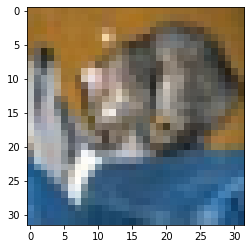

In [10]:
plt.imshow(examples[0].cpu().permute(1,2,0))
img = np.uint8((examples[0]*255).permute(1,2,0).cpu())
plt.imsave('examplesvanilla.png', img)

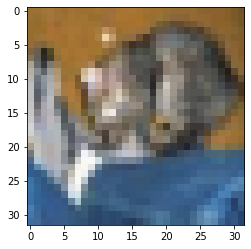

In [11]:
plt.imshow(adv_image_vanilla[0].cpu().permute(1,2,0))
img = np.uint8((adv_image_vanilla[0]*255).permute(1,2,0).cpu())
plt.imsave('examplesadv.png', img)

In [12]:
for epoch in range(0, 25):

    # train for one epoch
    print('current lr {:.5e}'.format(optimizer.param_groups[0]['lr']))
    train(train_loader, model, criterion, optimizer, epoch, normalizer, 'canny')
    lr_scheduler.step()

    # evaluate on validation set
    prec1 = validate(val_loader, model, criterion, normalizer, 'canny')

    # remember best prec@1 and save checkpoint
    is_best = prec1 > best_prec1
    best_prec1 = max(prec1, best_prec1)

    if epoch > 0 and epoch % 10 == 0:
        save_checkpoint({
            'epoch': epoch + 1,
            'state_dict': model.state_dict(),
#             'best_prec1': best_prec1,
        }, is_best,  filename=os.path.join('', 'checkpoint_canny_64.th'))

    save_checkpoint({
        'state_dict': model.state_dict(),
#         'best_prec1': best_prec1,
    }, is_best, filename=os.path.join('', 'resnet32_canny_64.th'))

current lr 5.00000e-02


KeyboardInterrupt: 